### Mark Hoogendoorn and Burkhardt Funk (2017)              
Machine Learning for the Quantified Self               
Springer, 
Chapter 7    

In [46]:
from util.VisualizeDataset import VisualizeDataset
from Chapter7.PrepareDatasetForLearning import PrepareDatasetForLearning
from Chapter7.LearningAlgorithms import ClassificationAlgorithms
from Chapter7.LearningAlgorithms import RegressionAlgorithms
from Chapter7.Evaluation import ClassificationEvaluation
from Chapter7.Evaluation import RegressionEvaluation
from Chapter7.FeatureSelection import FeatureSelectionClassification
from Chapter7.FeatureSelection import FeatureSelectionRegression
import copy
import pandas as pd
from util import util
import matplotlib.pyplot as plot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from util import ClassificationReport
import os

In [47]:
DataViz = VisualizeDataset()

# Read the result from the previous chapter, and make sure the index is of the type datetime.
dataset_path = 'intermediate_datafiles/'

export_tree_path = 'Example_graphs/Chapter7/'

try:
    dataset = pd.read_csv(dataset_path + 'chapter5_result.csv', index_col=0)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e

if not os.path.exists(export_tree_path):
    os.makedirs(export_tree_path)

dataset.index = pd.to_datetime(dataset.index, format='%Y-%m-%d %H:%M:%S.%f'[:-3])

In [48]:
# Remove unnecessary columns
del dataset['category']
del dataset['set']

In [49]:
# Split off the data of one participant
individual_data = dataset[dataset['participant'] == dataset['participant'].unique()[3]]
remaining_data = dataset[dataset['participant'] != dataset['participant'].unique()[3]]

In [50]:
# Remove unnecessary columns
del individual_data['participant']
del remaining_data['participant']

In [51]:
# We create a single column with the categorical attribute representing our class. Furthermore, we use 70% of our data
# for training and the remaining 30% as an independent test set. We select the sets based on stratified sampling. We remove
# cases where we do not know the label.

prepare = PrepareDatasetForLearning()

train_X, test_X, train_y, test_y = prepare.split_single_dataset_classification(remaining_data, ['label'], 'like', 0.7, filter=True, temporal=False)

print 'Training set length is: ', len(train_X.index)
print 'Test set length is: ', len(test_X.index)

Training set length is:  2634
Test set length is:  1129


In [52]:
# 10 best perfoming features
selected_features = ['pca_2',
                     'acc_y',
                     'pca_3',
                     'gyr_x_temp_std_ws_4',
                     'acc_r_pse',
                     'acc_x_temp_mean_ws_4',
                     'acc_r_freq_0.25_Hz_ws_4',
                     'gyr_r',
                     'acc_r_freq_0.0_Hz_ws_4',
                     'gyr_r_freq_weighted']

In [53]:
# Load algorithms
learner = ClassificationAlgorithms()
eval = ClassificationEvaluation()

In [54]:
# Train a random forest and predict class labels
class_train_y, class_test_y, class_train_prob_y, class_test_prob_y, model = learner.random_forest(train_X[selected_features], train_y, test_X[selected_features],
                                                                                           gridsearch=True, print_model_details=True)

{'n_estimators': 100, 'criterion': 'entropy', 'min_samples_leaf': 2}
Feature importance random forest:
acc_y  &  0.297091042792
pca_2  &  0.218747996519
acc_x_temp_mean_ws_4  &  0.18697222202
pca_3  &  0.137998163527
gyr_x_temp_std_ws_4  &  0.0443653138123
gyr_r  &  0.0374448117909
acc_r_freq_0.0_Hz_ws_4  &  0.028238840982
acc_r_pse  &  0.0255383702779
acc_r_freq_0.25_Hz_ws_4  &  0.012812681938
gyr_r_freq_weighted  &  0.0107905563407


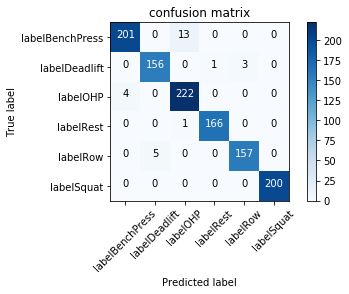

In [55]:
# Performance on the test data of the same participant
test_cm = eval.confusion_matrix(test_y, class_test_y, class_train_prob_y.columns)
DataViz.plot_confusion_matrix(test_cm, class_train_prob_y.columns, normalize=False)

In [56]:
accuracy_score(test_y, class_test_y)

0.97608503100088573

In [57]:
# Prepare the remaining data for testing 
# For convience, we use the prepare.split_single_dataset_classification
# but use 95% for the test split
r_train_X, r_test_X, r_train_y, r_test_y = prepare.split_single_dataset_classification(individual_data, ['label'], 'like', 0.05, filter=True, temporal=False)

In [58]:
# Make predictions using the trained model 
pred_prob_training_y = model.predict_proba(r_train_X[selected_features])
pred_prob_test_y = model.predict_proba(r_test_X[selected_features])
pred_training_y = model.predict(r_train_X[selected_features])
pred_test_y = model.predict(r_test_X[selected_features])
frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=model.classes_)
frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=model.classes_)

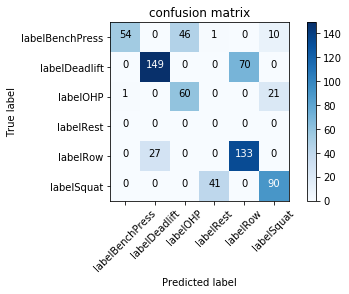

In [59]:
test_cm = eval.confusion_matrix(r_test_y, pred_test_y, frame_prob_training_y.columns)
DataViz.plot_confusion_matrix(test_cm, frame_prob_training_y.columns, normalize=False)

In [60]:
accuracy_score(r_test_y, pred_test_y)

0.69132290184921763